In [1]:
# Import libraries
## for profiling
from profiler.main import profile

# for titiler-xarray
from typing import Any
from titiler.xarray.factory import xarray_open_dataset, update_dataset
import morecantile
from rio_tiler.io import XarrayReader

# for titiler-pgstac
from titiler.pgstac.mosaic import PGSTACBackend
from typing import Any, Dict, List, Tuple
from rio_tiler.mosaic import mosaic_reader
from rio_tiler.models import ImageData
from geojson_pydantic import Polygon

# Only if wanting to see a picture
import io
from PIL import Image

In [2]:
search_dict: Dict[str, Any] = {
    'collections': ["CMIP6_ensemble_median_TAS"],
    'datetime': "1951-01-01T00:00:00Z",
    'bbox': [-180, -90, 180, 90]
}

xyz_tile = (0,0,0)

## Profile titiler-xarray

In [3]:
@profile(add_to_return=True, cprofile=True, quiet=True, log_library='s3fs')
def tile(src_path: str, x: int, y: int, z: int, *, variable: str, time_slice: str = None, **kwargs: Any):

    with xarray_open_dataset(
        src_path,
        z=z,
        decode_times=False,
        **kwargs,
    ) as dataset:
        dataarray, _ = update_dataset(dataset, variable=variable, time_slice=time_slice)
        
        with XarrayReader(dataarray) as src_dst:
            return src_dst.tile(x, y, z)

In [4]:
image_and_assets, logs = tile(
    "titiler-xarray/combined_cmip6_kerchunk.json", 
    *xyz_tile,
    time_slice = search_dict['datetime'],
    reference=True,
    variable="tas",
)
logs

Opening reference file


/Users/aimeebarciauskas/miniconda3/lib/python3.9/site-packages/titiler/xarray/factory.py:50: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  return xarray.open_dataset(src_path, **xr_open_args)
/Users/aimeebarciauskas/miniconda3/lib/python3.9/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


Setting up s3fs instance
RC: caching enabled? False (explicit option is False)
CALL: get_object - () - {'Bucket': 'climatedashboard-data', 'Key': 'cmip6/raw/monthly/CMIP6_ensemble_median/tas/tas_month_ensemble-median_historical_1950.nc', 'Range': 'bytes=21990-26789'}
CALL: get_object - () - {'Bucket': 'climatedashboard-data', 'Key': 'cmip6/raw/monthly/CMIP6_ensemble_median/tas/tas_month_ensemble-median_historical_1950.nc', 'Range': 'bytes=10470-21989'}
CALL: get_object - () - {'Bucket': 'climatedashboard-data', 'Key': 'cmip6/raw/monthly/CMIP6_ensemble_median/tas/tas_month_ensemble-median_historical_1950.nc', 'Range': 'bytes=45897-755594'}


{'cprofile': ['   ncalls  tottime  percall  cumtime  percall filename:lineno(function)',
  "       99    1.355    0.014    1.355    0.014 {method 'acquire' of '_thread.lock' objects}",
  '36196/238    0.065    0.000    0.218    0.001 core.py:776(_parseNoCache)',
  "      110    0.030    0.000    0.030    0.000 {method 'read' of '_io.BufferedReader' objects}",
  '        1    0.024    0.024    0.024    0.024 {rasterio._warp._reproject}',
  '    19030    0.016    0.000    0.023    0.000 results.py:136(__new__)',
  ' 4387/573    0.015    0.000    0.189    0.000 core.py:4108(parseImpl)',
  ' 4372/238    0.013    0.000    0.217    0.001 core.py:3861(parseImpl)',
  '90607/90227    0.012    0.000    0.014    0.000 {built-in method builtins.isinstance}',
  '    17526    0.011    0.000    0.018    0.000 core.py:2336(parseImpl)',
  '    25089    0.010    0.000    0.012    0.000 core.py:757(preParse)',
  '        1    0.010    0.010    0.010    0.010 {built-in method zlib.decompress}',
  '       

/Users/aimeebarciauskas/miniconda3/lib/python3.9/site-packages/rio_tiler/models.py:648: InvalidDatatypeWarning: Invalid type: `float32` for the `PNG` driver. Data will be rescaled using min/max type bounds or dataset_statistics.
  warnings.warn(


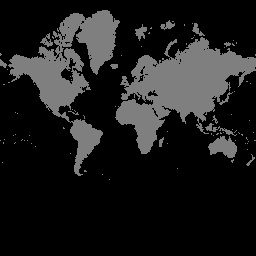

In [5]:
content = image_and_assets.render(
    img_format='PNG'
)

im = Image.open(io.BytesIO(content))
im

## Profile titiler-pgstac

In [6]:
pool = tile_pgstac.connection_pool()

NameError: name 'tile_pgstac' is not defined

In [ ]:
import tile_pgstac

@profile(add_to_return=True, cprofile=True, quiet=True, log_library = 'rasterio')
def tile(
    tile_x: int,
    tile_y: int,
    tile_z: int,
) -> Tuple[ImageData, List[str]]:
    
    backend = PGSTACBackend(pool=pool, input=tile_pgstac.mosaic_id(search_dict=search_dict, pool=pool))
    bbox = backend.tms.bounds(morecantile.Tile(tile_x, tile_y, tile_z))
    mosaic_assets = backend.get_assets(Polygon.from_bounds(*bbox))    

    def _reader(
        item: Dict[str, Any], x: int, y: int, z: int, **kwargs: Any
    ) -> ImageData:
        with backend.reader(item, tms=backend.tms, **backend.reader_options) as src_dst:
            return src_dst.tile(x, y, z, **kwargs)

    return mosaic_reader(mosaic_assets, _reader, tile_x, tile_y, tile_z, threads=10, **{"assets": ["data"]})  

In [ ]:
image_and_assets, logs = tile(*xyz_tile)
logs

In [ ]:
content = image_and_assets[0].render(
    img_format='PNG'
)

im = Image.open(io.BytesIO(content))
im